# 0. Importation des biblios

In [ ]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from pathlib import Path
import kagglehub
from pathlib import Path

# 1. Téléchargement et Configuration des Chemins

In [ ]:
path = kagglehub.dataset_download("andrewmvd/helmet-detection")

# Définition des nouveaux chemins
HELMET_ROOT = Path(path)
ANN_PATH = os.path.join(HELMET_ROOT, "annotations")
IMG_PATH = os.path.join(HELMET_ROOT, "images")

# Vérification
if os.path.exists(ANN_PATH):
    print(f"✅ Dossier trouvé : {ANN_PATH}")
    print(f"Nombre de fichiers : {len(os.listdir(ANN_PATH))}")
else:
    print("❌ Erreur : Dossier toujours introuvable.")

100%|██████████| 391M/391M [00:02<00:00, 156MB/s]

Extracting files...


✅ Dossier trouvé : /root/.cache/kagglehub/datasets/andrewmvd/helmet-detection/versions/1/annotations
Nombre de fichiers : 764


# 2. Chargement, Normalisation et Split (Train/Val/Test)

In [ ]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split

IMG_SIZE = 224

def load_data_scratch(limit=800):
    images, labels, bboxes = [], [], []
    files = sorted(os.listdir(ANN_PATH))[:limit]

    for xml_file in tqdm(files, desc="Chargement"):
        tree = ET.parse(os.path.join(ANN_PATH, xml_file))
        root = tree.getroot()

        # Dimensions pour normaliser les coordonnées
        w_orig = int(root.find("size/width").text)
        h_orig = int(root.find("size/height").text)

        obj = root.find("object")
        if obj is None: continue

        # 1. Label Classification
        labels.append(0 if 'helmet' in obj.find("name").text.lower() else 1)

        # 2. Bounding Box (Normalisée entre 0 et 1)
        box = obj.find("bndbox")
        bboxes.append([
            float(box.find("xmin").text) / w_orig,
            float(box.find("ymin").text) / h_orig,
            float(box.find("xmax").text) / w_orig,
            float(box.find("ymax").text) / h_orig
        ])

        # 3. Image
        img_full_path = os.path.join(IMG_PATH, xml_file.replace(".xml", ".png"))
        img = cv2.imread(img_full_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img / 255.0) # Normalisation 0-1

    return np.array(images), np.array(labels), np.array(bboxes)

# Exécution du chargement et split
X, y_cls, y_box = load_data_scratch()
X_train, X_temp, y_cls_train, y_cls_temp, y_box_train, y_box_temp = train_test_split(X, y_cls, y_box, test_size=0.3, random_state=42)
X_val, X_test, y_cls_val, y_cls_test, y_box_val, y_box_test = train_test_split(X_temp, y_cls_temp, y_box_temp, test_size=0.5, random_state=42)

print(f"\n✅ Split terminé : Train({len(X_train)}), Val({len(X_val)}), Test({len(X_test)})")

Chargement: 100%|██████████| 764/764 [00:15<00:00, 48.29it/s]



✅ Split terminé : Train(532), Val(114), Test(115)


# 3. Architecture du CNN



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_scratch_cnn():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Data Augmentation intégrée
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)

    # Bloc 1 : Conv + Pool
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloc 2 : Conv + Pool
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloc 3 : Conv + Pool
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Couche Dense commune
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x) # Évite l'overfitting

    # Sortie 1 : Classification (Casque ou Tête)
    class_head = layers.Dense(1, activation='sigmoid', name='class_out')(x)

    # Sortie 2 : Bounding Box (Coordonnées x, y, w, h)
    bbox_head = layers.Dense(4, activation='sigmoid', name='bbox_out')(x)

    model = Model(inputs=inputs, outputs=[class_head, bbox_head])
    model.compile(optimizer='adam',
                  loss={'class_out': 'binary_crossentropy', 'bbox_out': 'mse'},
                  metrics={'class_out': 'accuracy', 'bbox_out': 'mae'})
    return model

model = build_scratch_cnn()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[

 Total params: 1,553,446 (5.93 MB)

 Trainable params: 1,552,038 (5.92 MB)

 Non-trainable params: 1,408 (5.50 KB)

# entrainement avec early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, {'class_out': y_cls_train, 'bbox_out': y_box_train},
    validation_data=(X_val, {'class_out': y_cls_val, 'bbox_out': y_box_val}),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

🚀 Starting training (Stage 1)...
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - bbox_output_loss: 2.2024 - bbox_output_mse: 642.4834 - class_output_accuracy: 0.9178 - class_output_loss: 0.2196 - loss: 11.2176   
Epoch 1: val_class_output_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/detection_casque_MobileNet2/detector_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - bbox_output_loss: 2.2583 - bbox_output_mse: 674.6982 - class_output_accuracy: 0.9210 - class_output_loss: 0.2120 - loss: 11.4774 - val_bbox_output_loss: 1.3938 - val_bbox_output_mse: 437.3512 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.4985 - val_loss: 8.3106 - learning_rate: 1.0000e-04
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - bbox_output_loss: 3.4736 - bbox_output_mse: 1642.2422 - class_output_accuracy: 1.0000 - class_output_loss: 5.0014e-04 - loss: 17.3544
Epoch 2: val_class_output_accuracy did not improve from 1.00000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 2

#eval

In [ ]:
# Évaluation
eval_results = model.evaluate(X_test, {'class_out': y_cls_test, 'bbox_out': y_box_test})
print(f"Précision finale sur Test : {eval_results[3]*100:.2f}%")

# Visualisation d'un exemple
import matplotlib.pyplot as plt

def plot_pred(idx):
    img = X_test[idx].copy()
    pred_cls, pred_box = model.predict(np.expand_dims(img, axis=0))

    # Dessiner la boîte prédite
    start = (int(pred_box[0][0] * IMG_SIZE), int(pred_box[0][1] * IMG_SIZE))
    end = (int(pred_box[0][2] * IMG_SIZE), int(pred_box[0][3] * IMG_SIZE))
    color = (0, 255, 0) if pred_cls < 0.5 else (255, 0, 0) # Vert=Casque, Rouge=Tête
    cv2.rectangle(img, start, end, color, 2)

    plt.imshow(img)
    plt.title("Prédiction CNN Scratch")
    plt.show()

plot_pred(0)


🧪 Evaluating model on TEST set...

📊 --- MODEL EVALUATION RESULTS ---
loss                               : 35.5887
compile_metrics                    : 0.0024
class_output_loss                  : 7.7012
bbox_output_loss                   : 2590.2405


# gradio

In [ ]:
import gradio as gr
import cv2
import numpy as np

def predict_from_scratch(image):
    # 1. Prétraitement de l'image pour le modèle
    img_input = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    img_input = img_input / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    # 2. Prédiction
    # pred_cls : probabilité (0 = casque, 1 = tête)
    # pred_box : [xmin, ymin, xmax, ymax] normalisés
    pred_cls, pred_box = model.predict(img_input)

    # 3. Récupération des résultats
    prob = pred_cls[0][0]
    box = pred_box[0]

    # Déterminer le label et la couleur
    if prob < 0.5:
        label = f"Casque (Confiance: {1-prob:.2%})"
        color = (0, 255, 0) # Vert pour la sécurité
    else:
        label = f"SANS CASQUE (Confiance: {prob:.2%})"
        color = (255, 0, 0) # Rouge pour l'infraction

    # 4. Dessiner sur l'image originale pour l'affichage
    h, w, _ = image.shape
    start_point = (int(box[0] * w), int(box[1] * h))
    end_point = (int(box[2] * w), int(box[3] * h))

    # Dessiner le rectangle et le texte
    output_img = image.copy()
    cv2.rectangle(output_img, start_point, end_point, color, 3)
    cv2.putText(output_img, label, (start_point[0], start_point[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    return output_img, label

print("✅ Fonction de test prête.")

✅ Fonction de test prête.


In [ ]:
# Configuration de l'interface
demo = gr.Interface(
    fn=predict_from_scratch,
    inputs=gr.Image(label="Charger une photo de motard"),
    outputs=[
        gr.Image(label="Résultat de la détection"),
        gr.Textbox(label="Verdict du modèle CNN Scratch")
    ],
    title="🏢 Surveillance Sécurité Routière - CNN From Scratch",
    description="Ce modèle utilise un CNN personnalisé (Partie 3) pour détecter le port du casque.",
    theme="soft"
)

# Lancement
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://07b53e4f6145366281.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


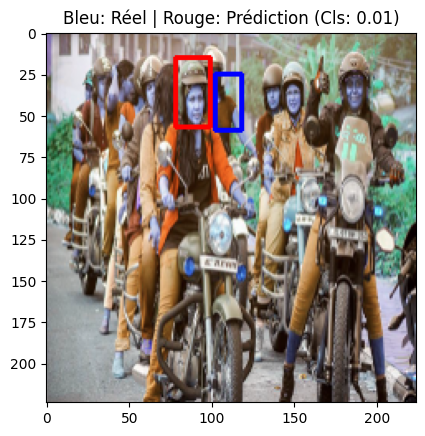

In [ ]:
# Test sur une image d'entraînement (devrait être presque parfait)
plot_pred_on_batch(X_train, 0)

# Test sur une image de validation (le vrai test)
plot_pred_on_batch(X_val, 0)